## **The data**
The data is used in [here](https://www.kaggle.com/simranjain17/insurance) around how much charges for a single person will be. The features for each person are:

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `


# **Libraries**

In [1]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

We first transform the regression problem into a classification problem. We split the data with respect to four quantiles. Therefore, the number of for each label of charges is roughly the same..

In [2]:
ins_data = pd.read_csv("insurance.csv")
ins_data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

So we split the data along the quantiles: 4700, 9300, 16600

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,3
1,18,male,33.770,1,no,southeast,0
2,28,male,33.000,3,no,southeast,0
3,33,male,22.705,0,no,northwest,3
4,32,male,28.880,0,no,northwest,0
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,2
1334,18,female,31.920,0,no,northeast,0
1335,18,female,36.850,0,no,southeast,0
1336,21,female,25.800,0,no,southwest,0


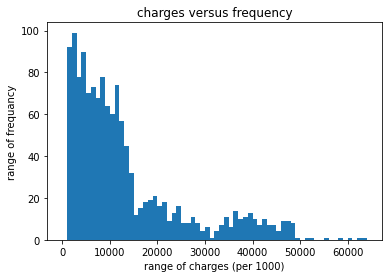

In [3]:
ins_data = pd.read_csv("insurance.csv")
from matplotlib import pyplot as plt
plt.title("charges versus frequency")
plt.xlabel("range of charges (per 1000)")
plt.ylabel("range of frequancy")
plt.hist(ins_data['charges'], bins=[1000*i for i in range (65)])
ins_data['charges'].describe()
def transform(x):
    if x<4700: return 0 # 25 percntile
    if x<9300: return 1 # median
    if x<16600: return 2 # 75 percentile
    return 3
ins_data["charges"]=ins_data["charges"].map(transform)
ins_data

(array([331., 334., 338., 335.]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

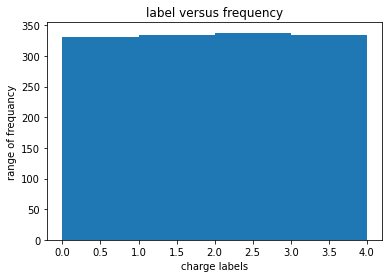

In [4]:
plt.title("label versus frequency")
plt.xlabel("charge labels")
plt.ylabel("range of frequancy")
plt.hist(ins_data["charges"],bins=[i for i in range(5)])

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [5]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


We split the train data and test data. All the train data and test data are the same for each part of the experiment (e).

The magnitude of train and test is 3:2. All the experiment are using the same train and test set.

In [6]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(ins_data.drop(target, axis = 1), ins_data[target], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["charges"] = target_train
test["charges"] = target_test

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [7]:
# Run pycaret setup
setup(data = train, 
      target = target, 
      test_data = test,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True,
      verbose = False)

([('Setup Config',
                                  Description             Value
   0                               session_id              5815
   1                                   Target           charges
   2                              Target Type        Multiclass
   3                            Label Encoded              None
   4                            Original Data          (802, 7)
   5                           Missing Values             False
   6                         Numeric Features                 2
   7                     Categorical Features                 4
   8                         Ordinal Features              True
   9                High Cardinality Features             False
   10                 High Cardinality Method              None
   11                   Transformed Train Set          (802, 9)
   12                    Transformed Test Set          (536, 9)
   13                      Shuffle Train-Test              True
   14                

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [8]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8728,0.9461,0.8738,0.8769,0.8698,0.8304,0.8333,0.1170
et,Extra Trees Classifier,0.8591,0.9432,0.8597,0.8648,0.8570,0.8121,0.8149,0.1130
gbc,Gradient Boosting Classifier,0.8566,0.9391,0.8576,0.8631,0.8536,0.8089,0.8121,0.0920
lightgbm,Light Gradient Boosting Machine,0.8504,0.9410,0.8512,0.8576,0.8476,0.8005,0.8040,0.0440
lr,Logistic Regression,0.8329,0.9324,0.8341,0.8398,0.8309,0.7773,0.7806,0.4610
dt,Decision Tree Classifier,0.8168,0.8777,0.8173,0.8207,0.8159,0.7556,0.7574,0.0050
lda,Linear Discriminant Analysis,0.8143,0.9268,0.8160,0.8231,0.8132,0.7525,0.7555,0.0050
ridge,Ridge Classifier,0.7407,0.0000,0.7440,0.7573,0.7317,0.6548,0.6642,0.0040
nb,Naive Bayes,0.6895,0.9112,0.6928,0.7844,0.6347,0.5860,0.6380,0.0050
knn,K Neighbors Classifier,0.6459,0.8176,0.6483,0.6073,0.6021,0.5283,0.5443,0.1950


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5815, verbose=0,
                       warm_start=False)

Currently `rf` gives the best result, but to be fair (with the data with synthetic generated samples), we choose `gbc`.

In [9]:
gbc = create_model("gbc") # Create logistic regression model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8765,0.9719,0.8797,0.8841,0.8750,0.8355,0.8390
1,0.8272,0.9388,0.8290,0.8285,0.8260,0.7696,0.7707
2,0.9250,0.9877,0.9237,0.9283,0.9252,0.8999,0.9008
3,0.8250,0.8848,0.8250,0.8501,0.8128,0.7667,0.7776
4,0.8625,0.9512,0.8625,0.8626,0.8618,0.8167,0.8172
5,0.8625,0.9382,0.8637,0.8743,0.8600,0.8166,0.8209
6,0.8625,0.9176,0.8631,0.8691,0.8572,0.8167,0.8215
7,0.8375,0.9367,0.8368,0.8370,0.8355,0.7831,0.7843
8,0.8875,0.9470,0.8887,0.8892,0.8864,0.8501,0.8513
9,0.8000,0.9167,0.8034,0.8076,0.7961,0.7338,0.7381


Above is the result for plain, without synthetic data result.